## Data preparation

In order to start running machine learning algorithms, we will need to prepare data accordingly. Hence, we will have to go through the following data preparation stages:

* **Data overview**
* **Data preprocessing**
* **Data splitting**
* **Data encoding**
* **Data scaling**

### Data overview

Before proceeding to exploring the data, we will need to upload all the necessary libraries, as well as import the data structures and functions that will be needed to conduct the study. Additionally, we will predefine some constants that will be used throughout the study, in particular, sizes of training, validation and test sets.

In [1]:
import re
from typing import Optional, Any

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    recall_score,
    ConfusionMatrixDisplay,
)
from sklearn.dummy import DummyClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

TRAIN_SET_SIZE = 0.6
VALID_SET_SIZE = 0.2
TEST_SET_SIZE = 0.2
RANDOM_STATE = 12345
MAX_DEPTH = 11
FOREST_SIZE_START = 20
FOREST_SIZE_STEP = 20
FOREST_SIZE_END = 100
F1_SCORE_THRESHOLD = 0.59
AUC_ROC_THRESHOLD = 0.5

Now that we have access to the `pandas` library, we can read and study the data that has been provided to us.

In [2]:
# Reading the data
clients_data = pd.read_csv("Churn.csv")

Now, using the `sample()` method, we will display 10 randomly selected rows of the `clients_data` DataFrame in order to see what the data looks like. Additionally, we will configure the random number generator as `random_state=RANDOM_STATE` to ensure reproducibility of the output result.

In [3]:
# Displaying 10 randomly selected rows
clients_data.sample(10, random_state=RANDOM_STATE)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
7867,7868,15697201,Yocum,640,Spain,Female,46,3.0,0.00,1,1,1,156260.08,0
1402,1403,15613282,Vorobyova,757,France,Male,29,8.0,130306.49,1,1,0,77469.38,0
8606,8607,15694581,Rawlings,807,Spain,Male,42,5.0,0.00,2,1,1,74900.90,0
8885,8886,15815125,Michael,668,Spain,Male,45,4.0,102486.21,2,1,1,158379.25,0
6494,6495,15752846,Pinto,699,France,Male,28,7.0,0.00,2,1,1,22684.78,0
9628,9629,15596624,Topp,662,France,Female,22,9.0,0.00,2,1,1,44377.65,0
7459,7460,15583724,Raymond,645,Spain,Female,29,4.0,0.00,2,1,1,74346.11,0
3964,3965,15714981,Sabbatini,476,France,Male,37,4.0,0.00,1,1,1,55775.84,1
7000,7001,15739548,Johnson,775,France,Male,28,9.0,111167.70,1,1,0,149331.01,0
4470,4471,15593795,Linton,516,Germany,Female,53,NaN,156674.20,1,1,0,118502.34,1


So, at first glance, we see quite a large number of features, not all of which we will need in the modeling process. We also see the target variable `Exited`, the behavior of which we will be interested in during this study. Obviously, in this case we will solve the problem of binary classification: the target is made up of zeros and ones (binary target) so, at first glance, the target has been encoded correctly. However, we cannot state anything with certainty about the data by looking at 10 rows of the DataFrame. Let's look deeper into the data and output general information about it using the `info()` method.

In [4]:
clients_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


We observe the following. The DataFrame contains data on 10,000 clients of "Beta Bank", which are characterized by 14 columns: 13 features and one target variable. As we can see, the data is expressed by different data types: `float64`, `int64` and `object`. Let's see in more detail what columns the DataFrame contains and what information they include:

<table>
<thead>
<tr><th>Features</th><th>Description</th></tr>
</thead>
<tbody>
<tr><td><code>RowNumber</code></td><td><i>Index of a row in the data</i></td></tr>
<tr><td><code>CustomerID</code></td><td><i>Unique identifier of a customer</i></td></tr>
<tr><td><code>Surname</code></td><td><i>Client's last name</i></td></tr>
<tr><td><code>CreditScore</code></td><td><i>Client's credit rating</i></td></tr>
<tr><td><code>Geography</code></td><td><i>Client's country of residence</i></td></tr>
<tr><td><code>Gender</code></td><td><i>Gender of a client</i></td></tr>
<tr><td><code>Age</code></td><td><i>Age of a client</i></td></tr>
<tr><td><code>Tenure</code></td><td><i>Duration of the bank's client status (years)</i></td></tr>
<tr><td><code>NumOfProducts</code></td><td><i>Number of bank products used by a client</i></td></tr>
<tr><td><code>HasCrCard</code></td><td><i>Credit card availability indicator</i></td></tr>
<tr><td><code>IsActiveMember</code></td><td><i>Client activity indicator</i></td></tr>
<tr><td><code>EstimatedSalary</code></td><td><i>Estimated salary of a client</i></td></tr>
<tr><td><code>Exited</code></td><td><i>Indicator of whether a client has churned</i></td></tr>
</tbody>
</table>

Next, we see that the number of `non-null` values is equal to the total number of objects in the dataset from column to column, with the exception of one column - `Tenure`. Moreover, this column should be characterized by an integer, not a floating data type (years cannot be fractional). Finally, the column names do not correspond to the standard of column names.

To conclude data overview step, let's build some histograms for the DataFrame we have.

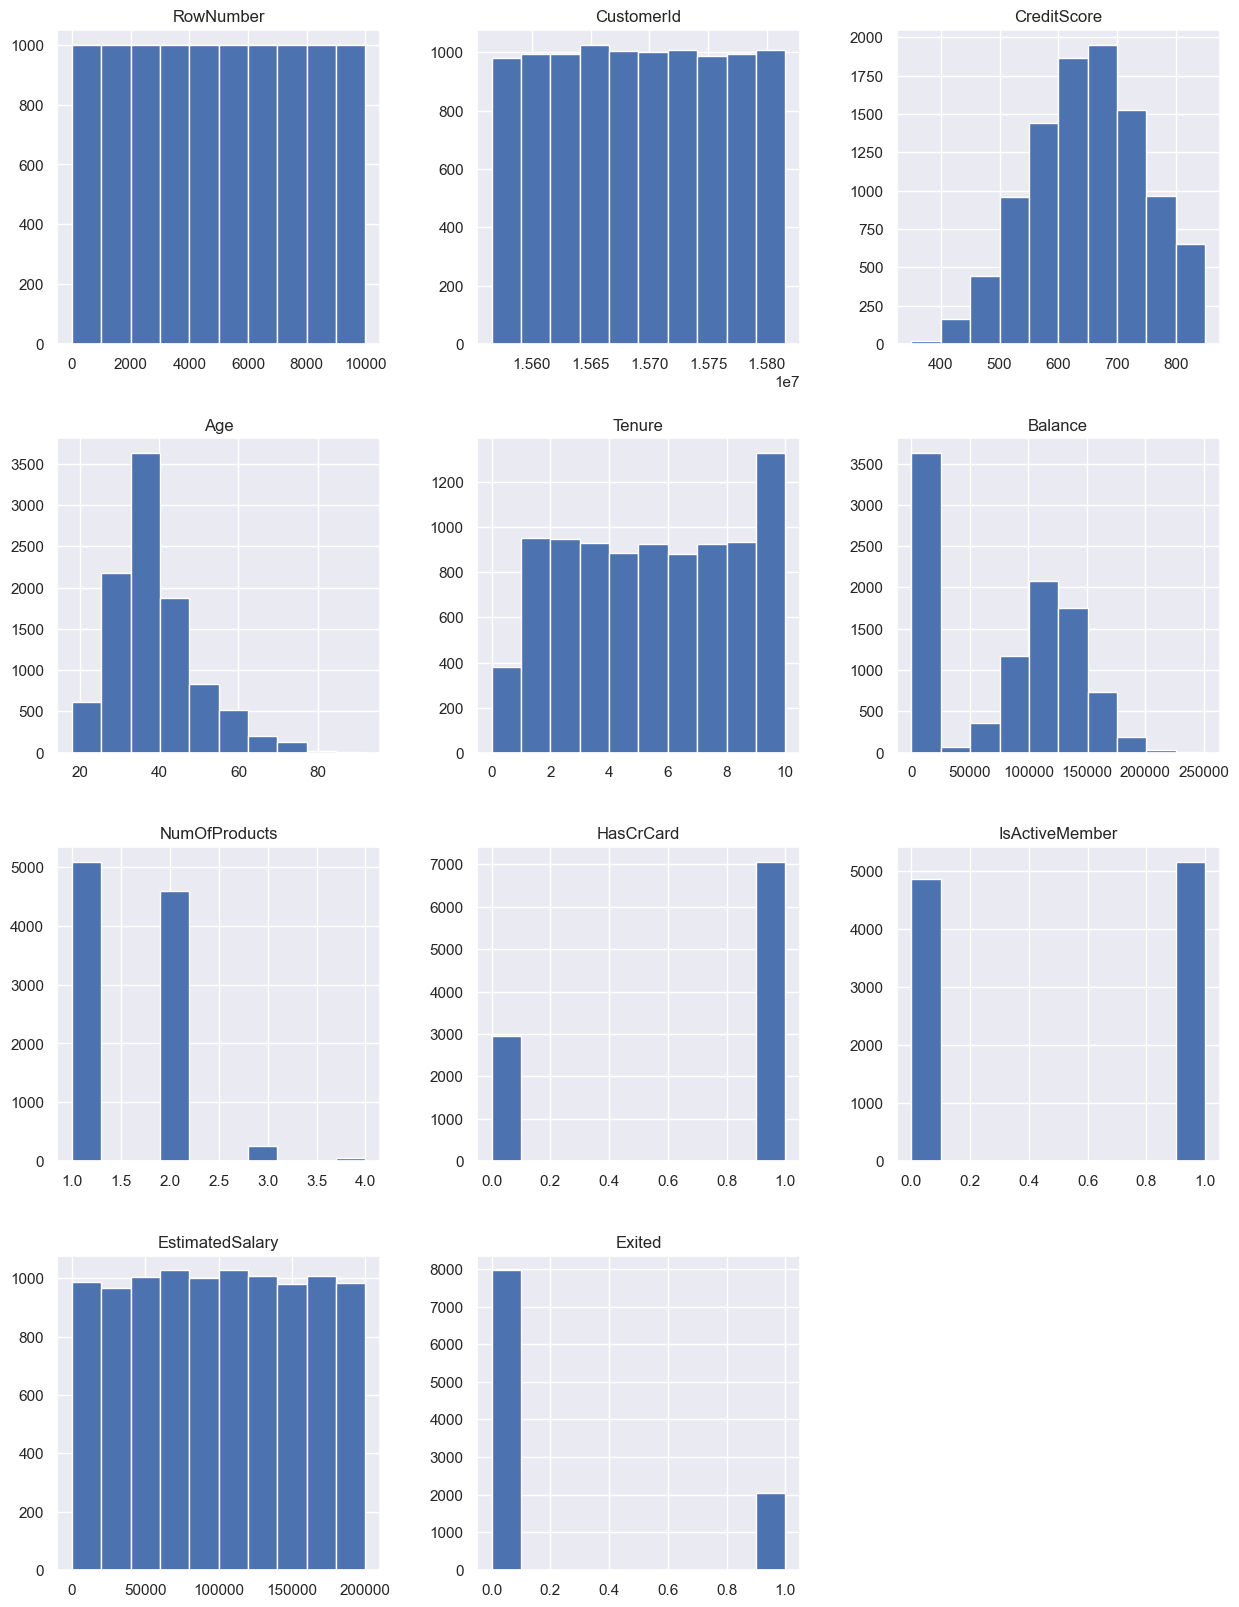

In [5]:
# Plotting histograms for all numeric columns
sns.set_theme(style="darkgrid")
clients_data.hist(figsize=(15, 20))
plt.show()

The `RowNumber` and `CustomerID` columns are not of interest to us, unlike the others. We see that the `Credit Score` and `Age` columns have a distribution close to normal, but with some skew. The columns `Tenure`, `Balance` and `EstimatedSalary` have distributions of a different form. The remaining variables have a limited number of values that they can take, which can be seen on the histograms. As for the target variable, we see that approximately 2,000 of the bank's customers have terminated their contracts and left, whilst the remaining 8,000 of them are still considered bank customers. Thus, the classes are unbalanced, which has to be dealt with after data preparation.

### Data preprocessing

Now it is necessary to perform data preprocessing. We don't need to do a large number of conversions: we just need to process the missing values and perform a type conversion in the `Tenure` column, as well as change the column names to those that will be easier to work with. Additionally, we will count the number of explicit duplicates, that is, identical rows.

#### Renaming columns

Let's start by changing the column names. In this case, we essentially need to put underscores between individual words (distinguishable by the uppercase letter) in the column names, and then make all uppercase letters lowercase. Here we can proceed, for example, in two ways:

1. On the one hand, we can do this directly: we can pass to the `columns` parameter of the `rename()` function a dictionary with old names (keys) and new names (values) as an argument. This is a working method, but filling in such a dictionary manually will take some time (we will need to manually type in 14 keys and 14 values). 

2. On the other hand, it is possible to use the functionality of regular expressions from the `re` library.

In [6]:
# Changing column names using regexes
clients_data = clients_data.rename(
    columns=lambda col_name: re.sub("(?<=[a-z])(?=[A-Z])", "_", col_name).lower()
)

Let's explain exactly how we replaced the column names. Firstly, using the `rename()` function, we pass to its `columns` parameter not a dictionary, but an anonymous lambda function, which essentially returns the result of performing some operation on the column names of the `clients_data` DataFrame. We change the column name using the `sub()` function from the regular expressions library `re`. The function takes in 3 parameters: 

* Certain pattern to be found inside the row (in this case, the row is the name of the column);
* What we need to replace a certain place in the row with; 
* The row itself where we need to look for matches. 

The last two arguments are clear, but let's explain how we made up the pattern. As mentioned before, we need to put underscores before each capital letter (except for the capital letter at the beginning of the column name). This is exactly what is done by the pattern `"(?<=[a-z])(?=[A-Z])"`, which finds all the places in the string between any lowercase letter and any subsequent uppercase letter. The function then places underscores in such places. Finally, we convert the column name to lowercase to get the result. 

Let's see if it was possible to correctly replace the column names by displaying the last five rows of the DataFrame.

In [7]:
clients_data.tail()

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1
9999,10000,15628319,Walker,792,France,Female,28,NaN,130142.79,1,1,0,38190.78,0


#### Missing values

Let's look at the missing values. To do this, lets' create a function `identify_missing_values()`, which will count the number and proportion of missing values in those columns where there are `NaN` values present.

In [8]:
def identify_missing_values(data: pd.DataFrame) -> Optional[pd.DataFrame]:
    """
    Computes a number and share of missing values
    in the DataFrame columns which have NaN-values
    present and displays data types of such columns.

    Args:
        data: DataFrame.

    Returns:
        pandas.DataFrame object with column names, data types,
        numbers of missing values and shares of NaN-values in
        such columns. In case there are not missing values present,
        an according message is shown and nothing is returned.
    """
    miss_vals_num_total = np.sum(data.isnull().sum())
    # Verifying NaN-values for nullity
    try:
        assert miss_vals_num_total != 0
    except AssertionError:
        print("Missing values are not found.")
        return
    else:
        # Creating a table with numbers of missing values
        miss_vals_num_cols = data.isnull().sum()[data.isnull().sum() > 0]
        cols = {"missing_count": miss_vals_num_cols.values}
        nans_df = pd.DataFrame(data=cols, index=miss_vals_num_cols.index).sort_values(
            by="missing_count", ascending=False
        )

        # Adding shares of missing values
        nans_df["missing_fraction"] = nans_df["missing_count"] / data.shape[0]
        nans_df["missing_fraction"] = nans_df["missing_fraction"].round(4)

        # Adding data types
        nans_df["dtype"] = data[nans_df.index].dtypes
        nans_df = nans_df[["dtype", "missing_count", "missing_fraction"]]

        return nans_df

In [9]:
nans_df = identify_missing_values(data=clients_data)
display(nans_df)

,dtype,missing_count,missing_fraction
tenure,float64,909,0.0909


As we saw earlier, we have missing values in only one column - `tenure`. The omissions account for only 9% of the data, so we will delete such rows with missing values to save time.

In [10]:
# Deleting rows with NaN-values (share < 10%)
clients_data = clients_data.dropna(
    subset=nans_df[nans_df["missing_fraction"] < 0.1].index
).reset_index(drop=True)

In [11]:
# Verification of all missing values deletion
nans_num = clients_data.isnull().sum()
assert nans_num.sum() == 0, f"{nans_num.sum()} missing values are left unprocessed."

As we can see, we have managed to deal with all missing values.

#### Data type conversions

Let's consider the general information about the data again.

In [12]:
clients_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9091 entries, 0 to 9090
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   row_number        9091 non-null   int64  
 1   customer_id       9091 non-null   int64  
 2   surname           9091 non-null   object 
 3   credit_score      9091 non-null   int64  
 4   geography         9091 non-null   object 
 5   gender            9091 non-null   object 
 6   age               9091 non-null   int64  
 7   tenure            9091 non-null   float64
 8   balance           9091 non-null   float64
 9   num_of_products   9091 non-null   int64  
 10  has_cr_card       9091 non-null   int64  
 11  is_active_member  9091 non-null   int64  
 12  estimated_salary  9091 non-null   float64
 13  exited            9091 non-null   int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 994.5+ KB


We see that only `tenure` column requires data type conversion. Hence, let's convert its type to `int64`. 

In [13]:
# Conversion to int64
clients_data["tenure"] = clients_data["tenure"].astype("int64")
display(clients_data["tenure"])

0        2
1        1
2        8
3        1
4        2
        ..
9086     2
9087     5
9088    10
9089     7
9090     3
Name: tenure, Length: 9091, dtype: int64

We see that data type has been successfully converted.

#### Identical rows

Lastly, let's check if the DataFrame has identical rows and if it does, we will delete them.

In [14]:
# Verification of identical rows being present
duplicates_num = clients_data.duplicated().sum()
if duplicates_num == 0:
    print("Duplicates have not been found.")
else:
    clients_data = clients_data.drop_duplicates().reset_index(drop=True)
    print(f"{duplicated_num} duplicates have been found and deleted.")

Duplicates have not been found.


### Data splitting

Now that we have preprocessed the data, we can move on to preparing the data for machine learning algorithms. To begin with, we will delete the columns that we will not need during the training of models. In this case, these are the columns `row_number`, `customer_id` and `surname`, since they will not carry any relevance regarding the client's choice to stay or terminate the contract with the bank. The first two columns contain purely technical information, and the client's last name cannot in any way influence the client's decision to churn from the bank.

In [15]:
clients_data = clients_data[clients_data.columns[3:]]
clients_data.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


After that we see that we now have all the information that will help us to use classification algorithms. Before splitting the data, let's separate features from target.

In [16]:
# Separating features from target
features = clients_data.drop(["exited"], axis=1)
target = clients_data["exited"]

Now let's divide the data into training, validation and test sets. We will use the following proportions:

* Training set => 60%
* Validation set => 20%
* Test set => 20%

We will split the data using the `train_test_split()` function from the `model_selection` module of the `sklearn` library. We will need to divide the data twice: first we will split the data in the proportion of 60-40 (training set and a mixture of validation and test sets), and then we will divide the validation and test data sets equally, thus achieving proportions of 20-20. 

In fact, we will conduct such a separation flexibly: we will define to cutoff points (`split_1` and `split_2`) that will be defined in accordance with the proportions that we have predefined at the beginning of the code. These points will then be used to accordingly split the data. 

In [17]:
# Defining cutoffs for splits
split_1 = 1 - TRAIN_SET_SIZE
split_2 = TEST_SET_SIZE / np.sum([VALID_SET_SIZE, TEST_SET_SIZE])

# Dividing data into a training set and a validation/test set
features_train, features_valid_test, target_train, target_valid_test = train_test_split(
    features, target, test_size=split_1, random_state=RANDOM_STATE
)

# Separating validation and test sets
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid_test, target_valid_test, test_size=split_2, random_state=RANDOM_STATE
)

Let's take a look if we have managed to correctly split the data, while respecting the proportions we have set earlier.

In [18]:
# Aggregating information about sizes of sets
df_columns = {
    "set_size": [
        features_train.shape[0],
        features_valid.shape[0],
        features_test.shape[0],
    ],
    "set_share": [
        features_train.shape[0] / features.shape[0],
        features_valid.shape[0] / features.shape[0],
        features_test.shape[0] / features.shape[0],
    ],
}
sets_info = pd.DataFrame(
    data=df_columns,
    index=["Training set", "Validation set", "Test set"],
)

# Verifying the proportions correctness
assert (np.sum(sets_info["set_size"]) == features.shape[0]) & (
    np.sum(sets_info["set_share"]) == 1.0
), "Incorrect proportions"

assert (
    np.sum(
        sets_info["set_share"].round(2).values
        == np.array([TRAIN_SET_SIZE, VALID_SET_SIZE, TEST_SET_SIZE])
    )
    == 3
), "Set sizes discrepancy"

# Tweaking the output format
sets_info.style.format({"set_size": "{:,}".format, "set_share": "{:.2f}".format})

,set_size,set_share
Training set,"5,454",0.60
Validation set,"1,818",0.20
Test set,"1,819",0.20


We see that we have managed to correctly split the data.

### Data encoding

We will conduct data encoding using `OneHotEncoder()`. For that, let's first define which categorical columns we will encode. These will be columns belonging to `object` data type.

In [19]:
# Choosing categorical columns to encode ("object" type)
cat_cols_to_encode = features_train.select_dtypes(include="object").columns.to_list()
print(f"Categorical columns to encode: {cat_cols_to_encode}")

Categorical columns to encode: ['geography', 'gender']


Now we can apply the encoder to these columns in the training set. Basically, by specifying `drop="first"` we will create *k-1* binary variables for each categorical column having *k* categories, thus dropping the first category of each column. Any unknown categories will be encoded as zeros as specified by `handle_unknown="ignore"`.

In [20]:
# Training the encoder
encoder_ohe = OneHotEncoder(drop="first", handle_unknown="ignore", sparse=False)
encoder_ohe.fit(features_train[cat_cols_to_encode])

# Encoding the training set
features_train_ohe = features_train.copy()
features_train_ohe[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(
    features_train[cat_cols_to_encode]
)
features_train_ohe = features_train_ohe.drop(cat_cols_to_encode, axis=1)
features_train_ohe.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
8483,727,28,2,110997.76,1,1,0,101433.76,0.0,0.0,0.0
3431,537,26,7,106397.75,1,0,0,103563.23,0.0,0.0,1.0
6770,610,40,9,0.00,1,1,1,149602.54,0.0,0.0,1.0
1350,576,36,6,0.00,2,1,1,48314.00,0.0,0.0,1.0
4047,549,31,4,0.00,2,0,1,25684.85,0.0,0.0,1.0


Accordingly, we can make similar transformations to the validation and test sets.

In [21]:
# Encoding the validation set
features_valid_ohe = features_valid.copy()
features_valid_ohe[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(
    features_valid[cat_cols_to_encode]
)
features_valid_ohe = features_valid_ohe.drop(cat_cols_to_encode, axis=1)
features_valid_ohe.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
6754,516,45,4,0.00,1,1,0,95273.73,0.0,0.0,0.0
7828,768,40,8,0.00,2,0,1,69080.46,0.0,0.0,0.0
1545,730,45,6,152880.97,1,0,0,162478.11,1.0,0.0,1.0
4935,751,29,1,135536.50,1,1,0,66825.33,0.0,0.0,1.0
8176,688,32,6,124179.30,1,1,1,138759.15,0.0,1.0,1.0


In [22]:
# Encoding the test set
features_test_ohe = features_test.copy()
features_test_ohe[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(
    features_test[cat_cols_to_encode]
)
features_test_ohe = features_test_ohe.drop(cat_cols_to_encode, axis=1)
features_test_ohe.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
4684,814,31,4,0.00,2,1,1,142029.17,0.0,0.0,0.0
3773,607,36,10,106702.94,2,0,0,198313.69,1.0,0.0,1.0
6665,632,42,6,59972.26,2,0,1,148172.94,1.0,0.0,1.0
6777,686,35,8,105419.73,1,1,0,35356.46,0.0,0.0,0.0
3143,538,42,1,98548.62,2,0,1,94047.75,1.0,0.0,0.0


### Data scaling

Before proceeding to scaling the data, we need to define which columns we will scale. It should be noted that we will not apply a scaler to already encoded categorical columns with less than 5 categories. Other columns will be transformed.

In [23]:
# Choosing numeric columns to scale
num_cols = features_train.select_dtypes(exclude="object").columns.to_list()
num_cols_to_scale = []
num_cols_intact = []
for col in num_cols:
    if len(features_train[col].unique()) < 5:
        num_cols_intact.append(col)
    else:
        num_cols_to_scale.append(col)
print(f"Numeric columns to scale: {num_cols_to_scale}")
print(f"Numeric columns intact: {num_cols_intact}")

Numeric columns to scale: ['credit_score', 'age', 'tenure', 'balance', 'estimated_salary']
Numeric columns intact: ['num_of_products', 'has_cr_card', 'is_active_member']


Now we are ready to apply `StandardScaler()` and train it on the training set.

In [24]:
# Training the scaler and scaling the training set
scaler = StandardScaler()
features_train_scaled = features_train_ohe.copy()
features_train_scaled[num_cols_to_scale] = scaler.fit_transform(
    features_train_scaled[num_cols_to_scale]
)
features_train_scaled.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
8483,0.809075,-1.039327,-1.025995,0.554904,1,1,0,0.019508,0.0,0.0,0.0
3431,-1.152518,-1.227561,0.696524,0.480609,1,0,0,0.056167,0.0,0.0,1.0
6770,-0.398853,0.090079,1.385532,-1.237830,1,1,1,0.848738,0.0,0.0,1.0
1350,-0.749875,-0.286389,0.352020,-1.237830,2,1,1,-0.894953,0.0,0.0,1.0
4047,-1.028628,-0.756975,-0.336987,-1.237830,2,0,1,-1.284516,0.0,0.0,1.0


We do the same thing on the validation and test sets.

In [25]:
# Scaling the validation set
features_valid_scaled = features_valid_ohe.copy()
features_valid_scaled[num_cols_to_scale] = scaler.transform(
    features_valid_scaled[num_cols_to_scale]
)
features_valid_scaled.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
6754,-1.369326,0.560665,-0.336987,-1.237830,1,1,0,-0.086537,0.0,0.0,0.0
7828,1.232367,0.090079,1.041028,-1.237830,2,0,1,-0.537457,0.0,0.0,0.0
1545,0.840048,0.560665,0.352020,1.231363,1,0,0,1.070393,1.0,0.0,1.0
4935,1.056856,-0.945210,-1.370498,0.951231,1,1,0,-0.576279,0.0,0.0,1.0
8176,0.406433,-0.662858,0.352020,0.767800,1,1,1,0.662068,0.0,1.0,1.0


In [26]:
# Scaling the test set
features_test_scaled = features_test_ohe.copy()
features_test_scaled[num_cols_to_scale] = scaler.transform(
    features_test_scaled[num_cols_to_scale]
)
features_test_scaled.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
4684,1.707279,-0.756975,-0.336987,-1.237830,2,1,1,0.718362,0.0,0.0,0.0
3773,-0.429826,-0.286389,1.730036,0.485538,2,0,0,1.687305,1.0,0.0,1.0
6665,-0.171721,0.278313,0.352020,-0.269213,2,0,1,0.824128,1.0,0.0,1.0
6777,0.385784,-0.380507,1.041028,0.464813,1,1,0,-1.118018,0.0,0.0,0.0
3143,-1.142194,0.278313,-1.370498,0.353837,2,0,1,-0.107642,1.0,0.0,0.0


**Conclusion**

At this stage, the data was carefully studied and a few problems were identified (missing values, incorrect data type and incorrect column names), which were corrected as a result of data preprocessing. Further, the data was brought to the proper form by applying data partitioning into training, validation and test sets as well as using One-Hot Encoding and Standard Scaling for preparing the data for machine learning algorithms.

## Ignoring imbalance

### Classes balance analysis

Now let's move on to studying the class balance. To do this, we will build a bar chart, where we will indicate what the percentage of the observations in the target variable for the training sample belongs to each class. We are interested in the training sample, because it is important to us to understand whether the algorithms will learn from balanced or unbalanced data. Since we will consider the structure of the target variable multiple times, let's write a function called `show_class_struct()` that will show a plot with the class structure of the target variable.

In [27]:
def plot_class_structure(
    target_var: pd.Series, xlabel_name: str, ylabel_name: str, title_name: str
) -> Any:
    """
    Shows a bar chart with shares of objects
    belonging to a specific class.

    Args:
        target_var: Target-vector.
        xlabel_name: Name of X-axis.
        ylabel_name: Name of Y-axis.
        title_name: Title of a plot.

    Returns:
        Any object
    """
    target_var.value_counts(normalize=True).plot(
        kind="bar",
        xlabel=xlabel_name,
        ylabel=ylabel_name,
        title=title_name,
    )
    plt.xticks(rotation=0)
    plt.show()

Now we can call this function and understand whether class imbalance is present in our data.

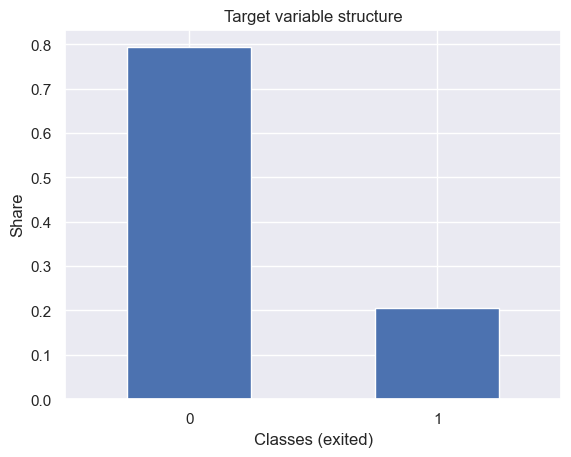

In [28]:
plot_class_structure(
    target_var=target_train,
    xlabel_name="Classes (exited)",
    ylabel_name="Share",
    title_name="Target variable structure",
)

We can see that approximately 80% of all objects are accounted for by those who stayed with the bank (class "0"), while the remaining 20% are gone. Thus, we are dealing with an unbalanced classification, in which models usually show poor learning performance.

### Hyperparameter tuning

In this section, we will consider models, provided that the class imbalance is ignored. We will conduct a series of hyperparameter tunings for the following three classification models:

* *Decision Tree Classifier*
* *Random Forest Classifier*
* *Logistic Regression*

We will focus on the value of the *F1* metric computed on the validation set. Additionally, we will calculate the *AUC-ROC* metric for each of the three best models.

#### Decision Tree

Let's start with the Decision Tree. We will consider the `max_depth` hyperparameter and will vary it for all integer values from 1 to 11.

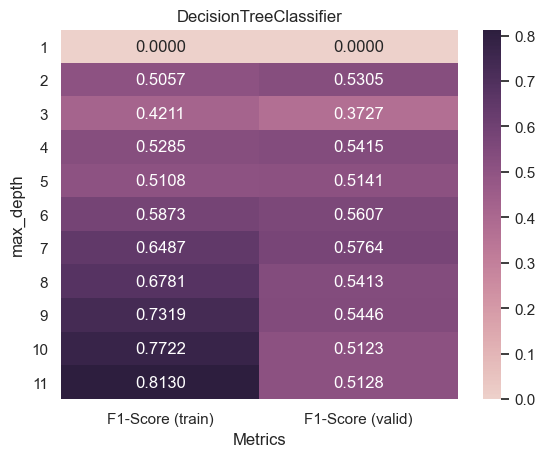


Best model: DecisionTreeClassifier(max_depth=7, random_state=12345)
Best F1-Score: 0.5764
AUC-ROC: 0.8346


In [29]:
# Unbalanced classification
# Hyperparameter tuning (Decision Tree) -> {"max_depth"}
best_model_DTC = None
best_result_DTC = 0
max_depths = []
f1_train_scores = []
f1_valid_scores = []
for depth in range(1, MAX_DEPTH + 1):
    model = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=depth)
    model.fit(features_train_scaled, target_train)
    # Computing predictions for training and validation sets
    predictions_train = model.predict(features_train_scaled)
    predictions_valid = model.predict(features_valid_scaled)
    # Computing F1-score for training and validation sets
    f1_train = f1_score(target_train, predictions_train)
    f1_valid = f1_score(target_valid, predictions_valid)
    # Collecting information
    max_depths.append(depth)
    f1_train_scores.append(f1_train)
    f1_valid_scores.append(f1_valid)
    # Making a decision about the best model
    if f1_valid > best_result_DTC:
        best_model_DTC = model
        best_result_DTC = f1_valid

# Creating a heatmap with hyperparameter tuning results
cols = {"F1-Score (train)": f1_train_scores, "F1-Score (valid)": f1_valid_scores}
results = pd.DataFrame(cols).set_index(pd.Series(max_depths))
heatmap = sns.heatmap(
    data=results, annot=True, fmt=".4f", cmap=sns.cubehelix_palette(as_cmap=True)
)
heatmap.set(title=f"{type(model).__name__}", ylabel="max_depth", xlabel="Metrics")
plt.yticks(rotation=0)
plt.show()

print(f"\nBest model: {best_model_DTC}")
print(f"Best F1-Score: {best_result_DTC:.4f}")

# Computing AUC-ROC for the best model
probabilities_valid = best_model_DTC.predict_proba(features_valid_scaled)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc_DTC = roc_auc_score(target_valid, probabilities_one_valid)
print(f"AUC-ROC: {auc_roc_DTC:.4f}")

The selection of the hyperparameter showed that the best model of the Decision Tree is a model with a depth of 7. It can be seen that for higher depths the model begins to overfit, which manifests itself in a large difference between the values of the metric *F1* for training and validation sets. We also see that the final model is quite different from the random one, which can be seen from the high value of the *AUC-ROC* metric.

#### Random Forest

Now let's consider a Random Forest model, where we will vary the number of trees (20, 40, 60, 80, 100), and also the depth of trees from 1 to 11.

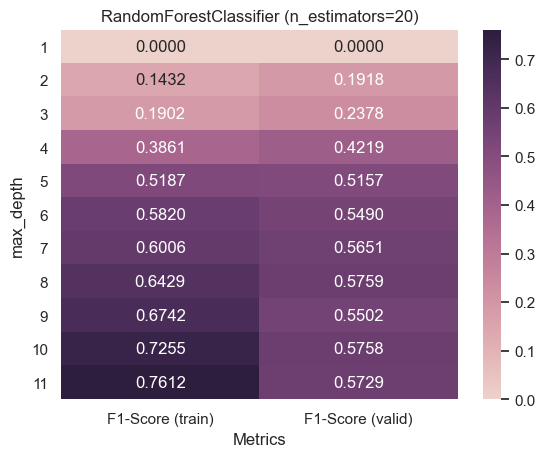

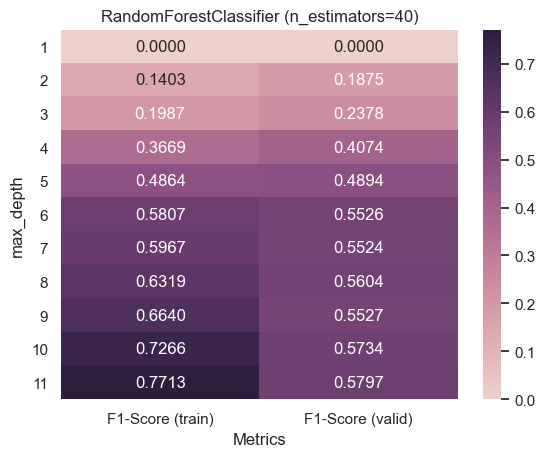

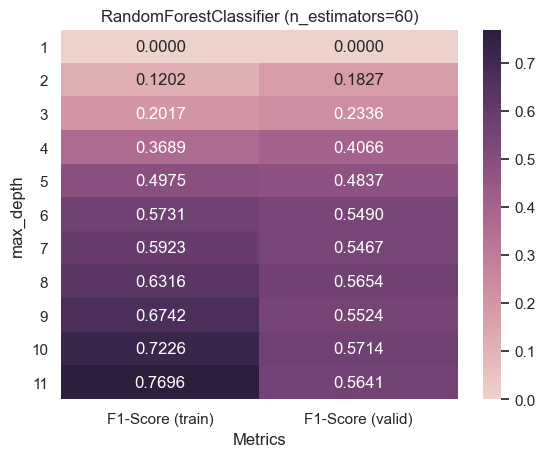

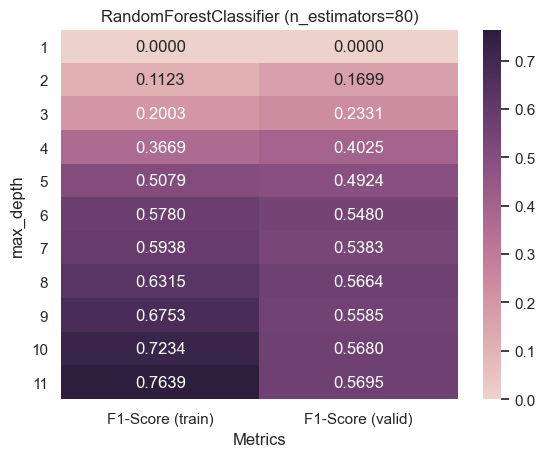

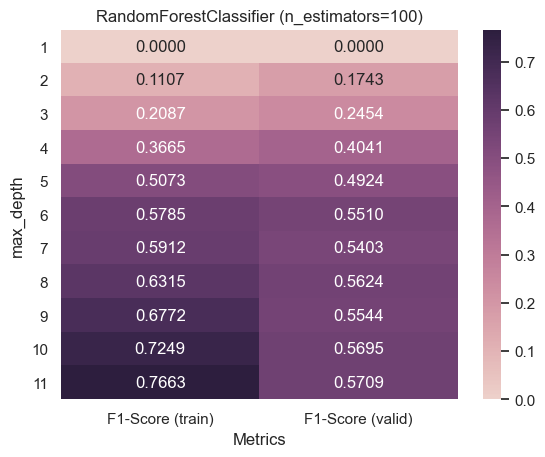


Best model: RandomForestClassifier(max_depth=11, n_estimators=40, random_state=12345)
Best F1-Score: 0.5797
AUC-ROC: 0.8677


In [30]:
# Unbalanced classification
# Hyperparameter tuning (Random Forest) -> {"n_estimators", "max_depth"}
best_model_RFC = None
best_result_RFC = 0
for est in range(
    FOREST_SIZE_START, FOREST_SIZE_END + FOREST_SIZE_STEP, FOREST_SIZE_STEP
):
    max_depths = []
    f1_train_scores = []
    f1_valid_scores = []
    for depth in range(1, MAX_DEPTH + 1):
        model = RandomForestClassifier(
            random_state=RANDOM_STATE, n_estimators=est, max_depth=depth
        )
        model.fit(features_train_scaled, target_train)

        predictions_train = model.predict(features_train_scaled)
        predictions_valid = model.predict(features_valid_scaled)

        f1_train = f1_score(target_train, predictions_train)
        f1_valid = f1_score(target_valid, predictions_valid)

        max_depths.append(depth)
        f1_train_scores.append(f1_train)
        f1_valid_scores.append(f1_valid)

        if f1_valid > best_result_RFC:
            best_model_RFC = model
            best_result_RFC = f1_valid

    cols = {"F1-Score (train)": f1_train_scores, "F1-Score (valid)": f1_valid_scores}
    results = pd.DataFrame(cols).set_index(pd.Series(max_depths))
    heatmap = sns.heatmap(
        data=results, annot=True, fmt=".4f", cmap=sns.cubehelix_palette(as_cmap=True)
    )
    heatmap.set(
        title=f"{type(model).__name__} (n_estimators={est})",
        ylabel="max_depth",
        xlabel="Metrics",
    )
    plt.yticks(rotation=0)
    plt.show()

print(f"\nBest model: {best_model_RFC}")
print(f"Best F1-Score: {best_result_RFC:.4f}")

probabilities_valid = best_model_RFC.predict_proba(features_valid_scaled)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc_RFC = roc_auc_score(target_valid, probabilities_one_valid)
print(f"AUC-ROC: {auc_roc_RFC:.4f}")

For this model, we see that the best model turned out to be a Random Forest with 40 trees with a depth of 11 each. The metric *F1* is 0.5797, and *AUC-ROC* is characterized by a fairly high value.

#### Logistic Regression

Finally, let's consider Logistic Regression, where we will vary the parameter `C` responsible for the degree of regularization.

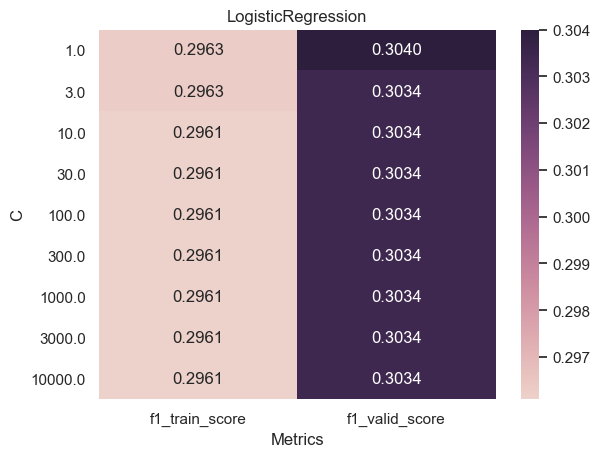


Best model: LogisticRegression(max_iter=1000, random_state=12345, solver='liblinear')
Best F1-Score: 0.3040
AUC-ROC: 0.7735


In [31]:
# Unbalanced classification
# Hyperparameter tuning (Logistic Regression) -> {"C"}
best_model_log = None
best_result_log = 0
c_values = []
f1_train_scores = []
f1_valid_scores = []
for c in [1.0, 3.0, 10.0, 30.0, 100.0, 300.0, 1000.0, 3000.0, 10000.0]:
    model = LogisticRegression(
        random_state=RANDOM_STATE, solver="liblinear", max_iter=1000, C=c
    )
    model.fit(features_train_scaled, target_train)

    predictions_train = model.predict(features_train_scaled)
    predictions_valid = model.predict(features_valid_scaled)

    f1_train = f1_score(target_train, predictions_train)
    f1_valid = f1_score(target_valid, predictions_valid)

    c_values.append(c)
    f1_train_scores.append(f1_train)
    f1_valid_scores.append(f1_valid)

    if f1_valid > best_result_log:
        best_model_log = model
        best_result_log = f1_valid

cols = {"f1_train_score": f1_train_scores, "f1_valid_score": f1_valid_scores}
results = pd.DataFrame(cols).set_index(pd.Series(c_values))
heatmap = sns.heatmap(
    data=results, annot=True, fmt=".4f", cmap=sns.cubehelix_palette(as_cmap=True)
)
heatmap.set(title=f"{type(model).__name__}", ylabel="C", xlabel="Metrics")
plt.yticks(rotation=0)
plt.show()

print(f"\nBest model: {best_model_log}")
print(f"Best F1-Score: {best_result_log:.4f}")

probabilities_valid = best_model_log.predict_proba(features_valid_scaled)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc_log = roc_auc_score(target_valid, probabilities_one_valid)
print(f"AUC-ROC: {auc_roc_log:.4f}")

The model showed worse results than previous models, which is evident from both metrics.

### Model comparison

Now let's compare the results of selecting hyperparameters for three models and display them on the screen to determine the best model for the case of ignoring the class imbalance.

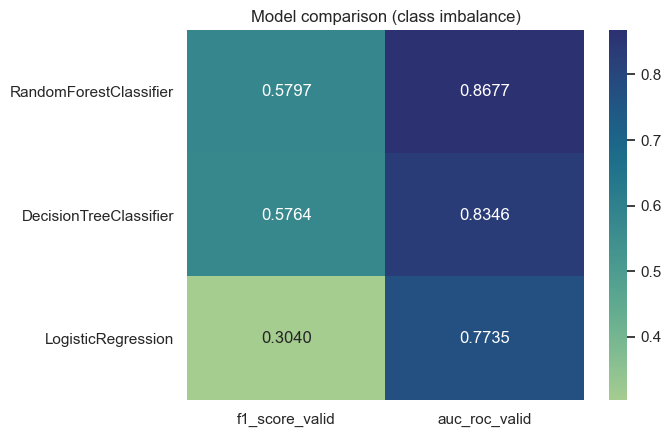


Best model: RandomForestClassifier(max_depth=11, n_estimators=40, random_state=12345)
Best F1-Score: 0.5797
Best AUC-ROC: 0.8677


In [32]:
# Creating a heatmap with results
cols = {
    "f1_score_valid": [best_result_DTC, best_result_RFC, best_result_log],
    "auc_roc_valid": [auc_roc_DTC, auc_roc_RFC, auc_roc_log],
}

models = [
    type(best_model_DTC).__name__,
    type(best_model_RFC).__name__,
    type(best_model_log).__name__,
]

df = pd.DataFrame(data=cols).set_index(pd.Series(models))
df_compare = df.sort_values(by="f1_score_valid", ascending=False)
heatmap = sns.heatmap(data=df_compare, annot=True, fmt=".4f", cmap="crest")
heatmap.set(title="Model comparison (class imbalance)")
plt.show()

# Determining the best model
df_compare = df_compare.reset_index()

if df_compare["index"][0] == type(best_model_DTC).__name__:
    best_model_unbalanced, best_f1_unbalanced, best_auc_roc_unbalanced = (
        best_model_DTC,
        best_result_DTC,
        auc_roc_DTC,
    )
elif df_compare["index"][0] == type(best_model_RFC).__name__:
    best_model_unbalanced, best_f1_unbalanced, best_auc_roc_unbalanced = (
        best_model_RFC,
        best_result_RFC,
        auc_roc_RFC,
    )
else:
    best_model_unbalanced, best_f1_unbalanced, best_auc_roc_unbalanced = (
        best_model_log,
        best_result_log,
        auc_roc_log,
    )
print(f"\nBest model: {best_model_unbalanced}")
print(f"Best F1-Score: {best_f1_unbalanced:.4f}")
print(f"Best AUC-ROC: {best_auc_roc_unbalanced:.4f}")

So, we see that the best model based on *F1* metric is the model of the Random Forest with 40 trees and a depth of 11.

**Conclusion**

In this section, an analysis of the balance of classes was carried out and a series of hyperparameters tunings were carried out for three selected classification models. The fact of the presence of an imbalance in the data was revealed, where it is expressed in proportions of 80-20. As a result of training models, the best model according to the *F1* metric is the model of the Random Forest with 40 trees and a depth of 11. In addition, the models were also tested for their differences from the random model using the *AUC-ROC* metric, as a result of which all models passed such a test, where the models of the Random Forest and the Decision Tree showed particularly good results.

## Accounting for class imbalance

Now we are starting to apply various methods to combat the imbalance in the data. We will carry out a similar series of hyperparameter tunings for the above models, simultaneously applying the following three ways to solve the problem of class imbalance:

* *Weighing classes*
* *Increasing sample size (Upsampling)*
* *Decreasing sample size (Downsampling)*

### Weighing classes

In order to apply this method, we do not need to radically change the code, but only specify `class_weight="balanced"` when defining the model.

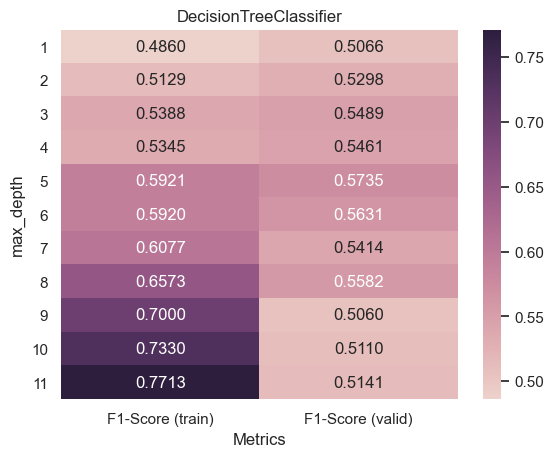


Best model: DecisionTreeClassifier(class_weight='balanced', max_depth=5, random_state=12345)
Best F1-Score: 0.5735
AUC-ROC: 0.8397


In [33]:
# Weighing classes
# Hyperparameter tuning (Decision Tree) -> {"max_depth"}
best_model_DTC = None
best_result_DTC = 0
max_depths = []
f1_train_scores = []
f1_valid_scores = []
for depth in range(1, MAX_DEPTH + 1):
    model = DecisionTreeClassifier(
        random_state=RANDOM_STATE, max_depth=depth, class_weight="balanced"
    )
    model.fit(features_train_scaled, target_train)

    predictions_train = model.predict(features_train_scaled)
    predictions_valid = model.predict(features_valid_scaled)

    f1_train = f1_score(target_train, predictions_train)
    f1_valid = f1_score(target_valid, predictions_valid)

    max_depths.append(depth)
    f1_train_scores.append(f1_train)
    f1_valid_scores.append(f1_valid)

    if f1_valid > best_result_DTC:
        best_model_DTC = model
        best_result_DTC = f1_valid

cols = {"F1-Score (train)": f1_train_scores, "F1-Score (valid)": f1_valid_scores}
results = pd.DataFrame(cols).set_index(pd.Series(max_depths))
heatmap = sns.heatmap(
    data=results, annot=True, fmt=".4f", cmap=sns.cubehelix_palette(as_cmap=True)
)
heatmap.set(title=f"{type(model).__name__}", ylabel="max_depth", xlabel="Metrics")
plt.yticks(rotation=0)
plt.show()

print(f"\nBest model: {best_model_DTC}")
print(f"Best F1-Score: {best_result_DTC:.4f}")

probabilities_valid = best_model_DTC.predict_proba(features_valid_scaled)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc_DTC = roc_auc_score(target_valid, probabilities_one_valid)
print(f"AUC-ROC: {auc_roc_DTC:.4f}")

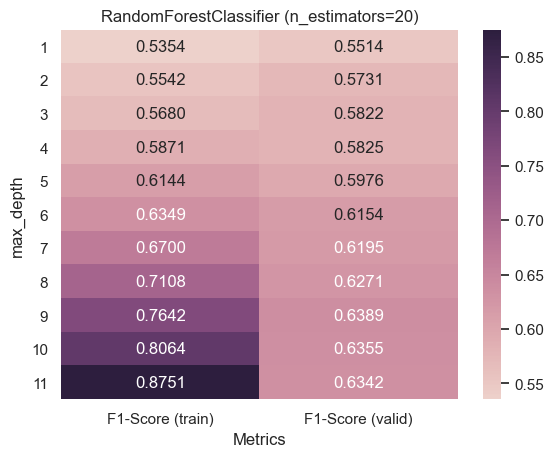

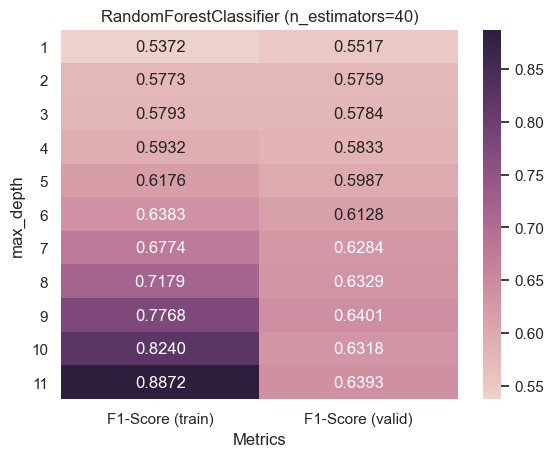

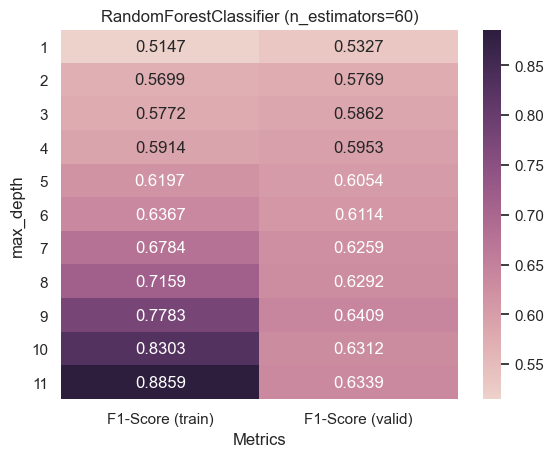

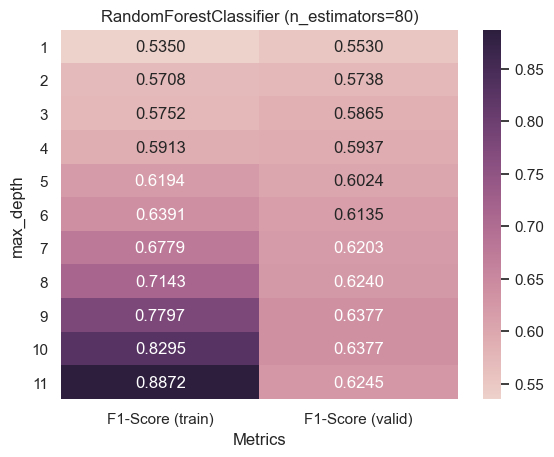

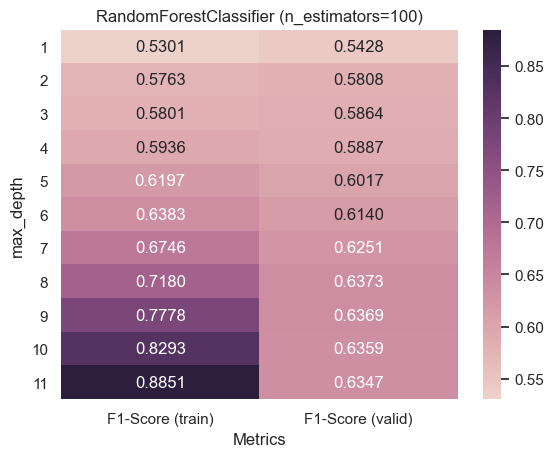


Best model: RandomForestClassifier(class_weight='balanced', max_depth=9, n_estimators=60,
                       random_state=12345)
Best F1-Score: 0.6409
AUC-ROC: 0.8670


In [34]:
# Weighing classes
# Hyperparameter tuning (Random Forest) -> {"n_estimators", "max_depth"}
best_model_RFC = None
best_result_RFC = 0
for est in range(
    FOREST_SIZE_START, FOREST_SIZE_END + FOREST_SIZE_STEP, FOREST_SIZE_STEP
):
    max_depths = []
    f1_train_scores = []
    f1_valid_scores = []
    for depth in range(1, MAX_DEPTH + 1):
        model = RandomForestClassifier(
            random_state=RANDOM_STATE,
            n_estimators=est,
            max_depth=depth,
            class_weight="balanced",
        )
        model.fit(features_train_scaled, target_train)

        predictions_train = model.predict(features_train_scaled)
        predictions_valid = model.predict(features_valid_scaled)

        f1_train = f1_score(target_train, predictions_train)
        f1_valid = f1_score(target_valid, predictions_valid)

        max_depths.append(depth)
        f1_train_scores.append(f1_train)
        f1_valid_scores.append(f1_valid)

        if f1_valid > best_result_RFC:
            best_model_RFC = model
            best_result_RFC = f1_valid

    cols = {"F1-Score (train)": f1_train_scores, "F1-Score (valid)": f1_valid_scores}
    results = pd.DataFrame(cols).set_index(pd.Series(max_depths))
    heatmap = sns.heatmap(
        data=results, annot=True, fmt=".4f", cmap=sns.cubehelix_palette(as_cmap=True)
    )
    heatmap.set(
        title=f"{type(model).__name__} (n_estimators={est})",
        ylabel="max_depth",
        xlabel="Metrics",
    )
    plt.yticks(rotation=0)
    plt.show()

print(f"\nBest model: {best_model_RFC}")
print(f"Best F1-Score: {best_result_RFC:.4f}")

probabilities_valid = best_model_RFC.predict_proba(features_valid_scaled)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc_RFC = roc_auc_score(target_valid, probabilities_one_valid)
print(f"AUC-ROC: {auc_roc_RFC:.4f}")

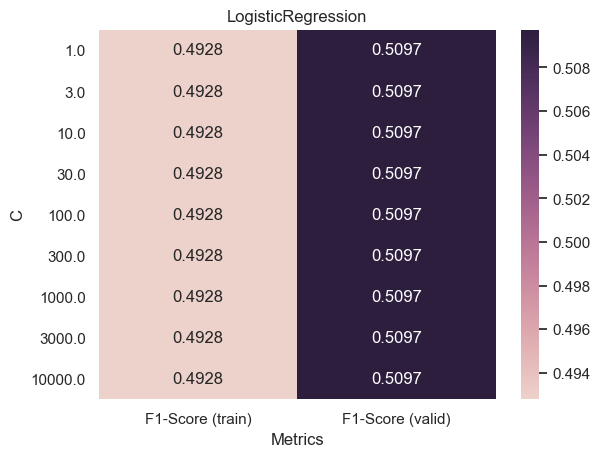


Best model: LogisticRegression(class_weight='balanced', max_iter=1000, random_state=12345,
                   solver='liblinear')
Best F1-Score: 0.5097
AUC-ROC: 0.7778


In [35]:
# Weighing classes
# Hyperparameter tuning (Logistic Regression) -> {"C"}
best_model_log = None
best_result_log = 0
c_values = []
f1_train_scores = []
f1_valid_scores = []
for c in [1.0, 3.0, 10.0, 30.0, 100.0, 300.0, 1000.0, 3000.0, 10000.0]:
    model = LogisticRegression(
        random_state=RANDOM_STATE,
        solver="liblinear",
        max_iter=1000,
        C=c,
        class_weight="balanced",
    )
    model.fit(features_train_scaled, target_train)

    predictions_train = model.predict(features_train_scaled)
    predictions_valid = model.predict(features_valid_scaled)

    f1_train = f1_score(target_train, predictions_train)
    f1_valid = f1_score(target_valid, predictions_valid)

    c_values.append(c)
    f1_train_scores.append(f1_train)
    f1_valid_scores.append(f1_valid)

    if f1_valid > best_result_log:
        best_model_log = model
        best_result_log = f1_valid

cols = {"F1-Score (train)": f1_train_scores, "F1-Score (valid)": f1_valid_scores}
results = pd.DataFrame(cols).set_index(pd.Series(c_values))
heatmap = sns.heatmap(
    data=results, annot=True, fmt=".4f", cmap=sns.cubehelix_palette(as_cmap=True)
)
heatmap.set(title=f"{type(model).__name__}", ylabel="C", xlabel="Metrics")
plt.yticks(rotation=0)
plt.show()

print(f"\nBest model: {best_model_log}")
print(f"Best F1-Score: {best_result_log:.4f}")

probabilities_valid = best_model_log.predict_proba(features_valid_scaled)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc_log = roc_auc_score(target_valid, probabilities_one_valid)
print(f"AUC-ROC: {auc_roc_log:.4f}")

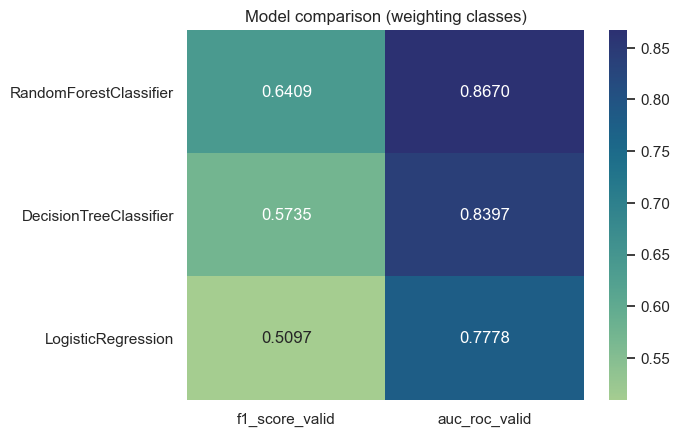


Best model: RandomForestClassifier(class_weight='balanced', max_depth=9, n_estimators=60,
                       random_state=12345)
Best F1-Score: 0.6409
Best AUC-ROC: 0.8670


In [36]:
# Creating a heatmap with results
cols = {
    "f1_score_valid": [best_result_DTC, best_result_RFC, best_result_log],
    "auc_roc_valid": [auc_roc_DTC, auc_roc_RFC, auc_roc_log],
}

models = [
    type(best_model_DTC).__name__,
    type(best_model_RFC).__name__,
    type(best_model_log).__name__,
]

df = pd.DataFrame(data=cols).set_index(pd.Series(models))
df_compare = df.sort_values(by="f1_score_valid", ascending=False)
heatmap = sns.heatmap(data=df_compare, annot=True, fmt=".4f", cmap="crest")
heatmap.set(title="Model comparison (weighting classes)")
plt.show()

# Determining the best model
df_compare = df_compare.reset_index()

if df_compare["index"][0] == type(best_model_DTC).__name__:
    best_model_weighted, best_f1_weighted, best_auc_roc_weighted = (
        best_model_DTC,
        best_result_DTC,
        auc_roc_DTC,
    )
elif df_compare["index"][0] == type(best_model_RFC).__name__:
    best_model_weighted, best_f1_weighted, best_auc_roc_weighted = (
        best_model_RFC,
        best_result_RFC,
        auc_roc_RFC,
    )
else:
    best_model_weighted, best_f1_weighted, best_auc_roc_weighted = (
        best_model_log,
        best_result_log,
        auc_roc_log,
    )
print(f"\nBest model: {best_model_weighted}")
print(f"Best F1-Score: {best_f1_weighted:.4f}")
print(f"Best AUC-ROC: {best_auc_roc_weighted:.4f}")

Now we can see that after weighting classes, the best model proved to be a Random Forest with 60 trees and a depth of 9. Notably, the value of *F1* metric increased pretty drastically in comparison with the case of ignoring classes imbalance.

### Increasing sample size

The next technique we will use is called upsampling, where we increase our sample size with the same data to achieve classes balance. This can be done by making use of `SMOTE` from `over_sampling` module of `imblearn` library for dealing with imbalanced data. We will apply this on the training set only, since this the data the models are training on.

In [37]:
# Upsampling the training data
oversample = SMOTE(random_state=RANDOM_STATE)
features_train_upsampled, target_train_upsampled = oversample.fit_resample(
    features_train_scaled, target_train
)

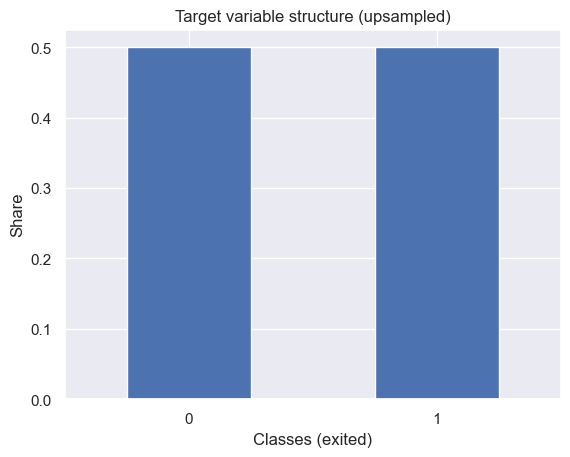

In [38]:
plot_class_structure(
    target_var=target_train_upsampled,
    xlabel_name="Classes (exited)",
    ylabel_name="Share",
    title_name="Target variable structure (upsampled)",
)

We can see that now we have managed to achieve class balance by supplying our data with the same data to attain equilibrium of classes.

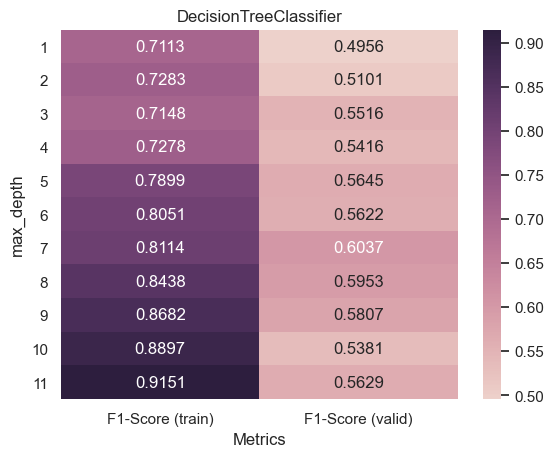


Best model: DecisionTreeClassifier(max_depth=7, random_state=12345)
Best F1-Score: 0.6037
AUC-ROC: 0.8185


In [39]:
# Upsampling
# Hyperparameter tuning (Decision Tree) -> {"max_depth"}
best_model_DTC = None
best_result_DTC = 0
max_depths = []
f1_train_scores = []
f1_valid_scores = []
for depth in range(1, MAX_DEPTH + 1):
    model = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=depth)
    model.fit(features_train_upsampled, target_train_upsampled)

    predictions_train = model.predict(features_train_upsampled)
    predictions_valid = model.predict(features_valid_scaled)

    f1_train = f1_score(target_train_upsampled, predictions_train)
    f1_valid = f1_score(target_valid, predictions_valid)

    max_depths.append(depth)
    f1_train_scores.append(f1_train)
    f1_valid_scores.append(f1_valid)

    if f1_valid > best_result_DTC:
        best_model_DTC = model
        best_result_DTC = f1_valid

cols = {"F1-Score (train)": f1_train_scores, "F1-Score (valid)": f1_valid_scores}
results = pd.DataFrame(cols).set_index(pd.Series(max_depths))
heatmap = sns.heatmap(
    data=results, annot=True, fmt=".4f", cmap=sns.cubehelix_palette(as_cmap=True)
)
heatmap.set(title=f"{type(model).__name__}", ylabel="max_depth", xlabel="Metrics")
plt.yticks(rotation=0)
plt.show()

print(f"\nBest model: {best_model_DTC}")
print(f"Best F1-Score: {best_result_DTC:.4f}")

probabilities_valid = best_model_DTC.predict_proba(features_valid_scaled)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc_DTC = roc_auc_score(target_valid, probabilities_one_valid)
print(f"AUC-ROC: {auc_roc_DTC:.4f}")

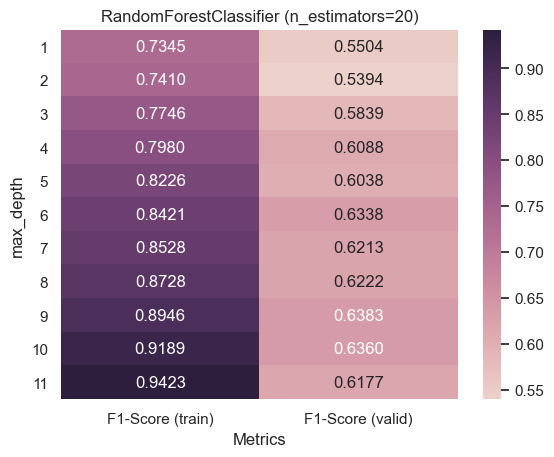

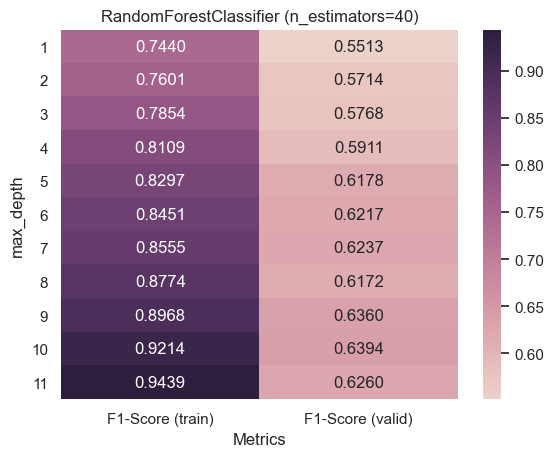

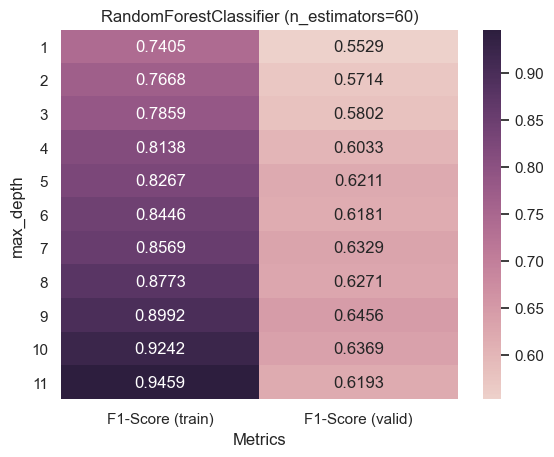

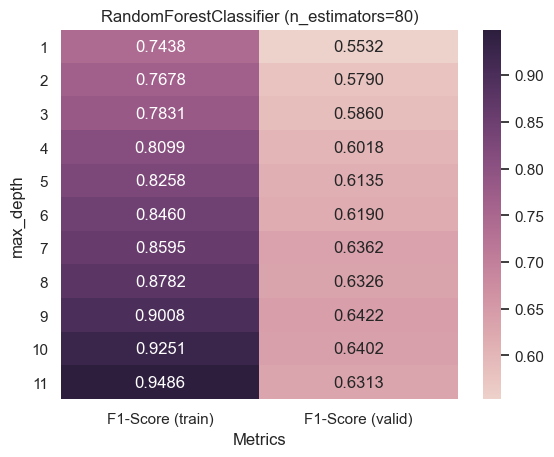

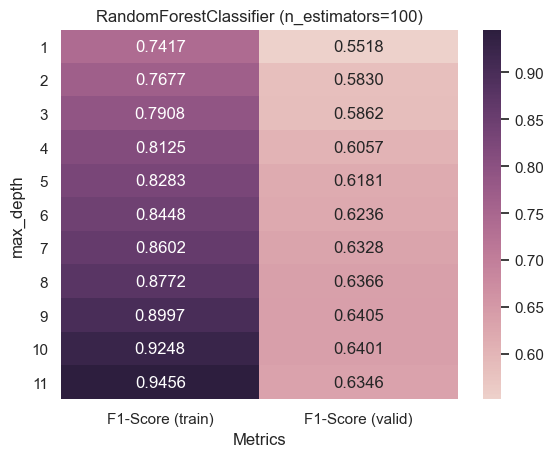


Best model: RandomForestClassifier(max_depth=9, n_estimators=60, random_state=12345)
Best F1-Score: 0.6456
AUC-ROC: 0.8686


In [40]:
# Upsampling
# Hyperparameter tuning (Random Forest) -> {"n_estimators", "max_depth"}
best_model_RFC = None
best_result_RFC = 0
for est in range(
    FOREST_SIZE_START, FOREST_SIZE_END + FOREST_SIZE_STEP, FOREST_SIZE_STEP
):
    max_depths = []
    f1_train_scores = []
    f1_valid_scores = []
    for depth in range(1, MAX_DEPTH + 1):
        model = RandomForestClassifier(
            random_state=RANDOM_STATE, n_estimators=est, max_depth=depth
        )
        model.fit(features_train_upsampled, target_train_upsampled)

        predictions_train = model.predict(features_train_upsampled)
        predictions_valid = model.predict(features_valid_scaled)

        f1_train = f1_score(target_train_upsampled, predictions_train)
        f1_valid = f1_score(target_valid, predictions_valid)

        max_depths.append(depth)
        f1_train_scores.append(f1_train)
        f1_valid_scores.append(f1_valid)

        if f1_valid > best_result_RFC:
            best_model_RFC = model
            best_result_RFC = f1_valid

    cols = {"F1-Score (train)": f1_train_scores, "F1-Score (valid)": f1_valid_scores}
    results = pd.DataFrame(cols).set_index(pd.Series(max_depths))
    heatmap = sns.heatmap(
        data=results, annot=True, fmt=".4f", cmap=sns.cubehelix_palette(as_cmap=True)
    )
    heatmap.set(
        title=f"{type(model).__name__} (n_estimators={est})",
        ylabel="max_depth",
        xlabel="Metrics",
    )
    plt.yticks(rotation=0)
    plt.show()

print(f"\nBest model: {best_model_RFC}")
print(f"Best F1-Score: {best_result_RFC:.4f}")

probabilities_valid = best_model_RFC.predict_proba(features_valid_scaled)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc_RFC = roc_auc_score(target_valid, probabilities_one_valid)
print(f"AUC-ROC: {auc_roc_RFC:.4f}")

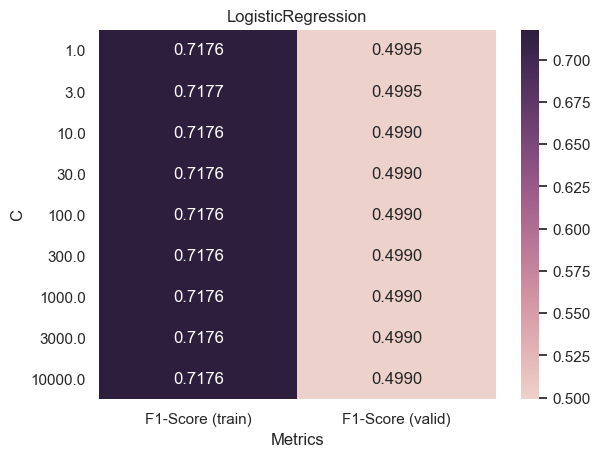


Best model: LogisticRegression(max_iter=1000, random_state=12345, solver='liblinear')
Best F1-Score: 0.4995
AUC-ROC: 0.7659


In [41]:
# Upsampling
# Hyperparameter tuning (Logistic Regression) -> {"C"}
best_model_log = None
best_result_log = 0
c_values = []
f1_train_scores = []
f1_valid_scores = []
for c in [1.0, 3.0, 10.0, 30.0, 100.0, 300.0, 1000.0, 3000.0, 10000.0]:
    model = LogisticRegression(
        random_state=RANDOM_STATE, solver="liblinear", max_iter=1000, C=c
    )
    model.fit(features_train_upsampled, target_train_upsampled)

    predictions_train = model.predict(features_train_upsampled)
    predictions_valid = model.predict(features_valid_scaled)

    f1_train = f1_score(target_train_upsampled, predictions_train)
    f1_valid = f1_score(target_valid, predictions_valid)

    c_values.append(c)
    f1_train_scores.append(f1_train)
    f1_valid_scores.append(f1_valid)

    if f1_valid > best_result_log:
        best_model_log = model
        best_result_log = f1_valid

cols = {"F1-Score (train)": f1_train_scores, "F1-Score (valid)": f1_valid_scores}
results = pd.DataFrame(cols).set_index(pd.Series(c_values))
heatmap = sns.heatmap(
    data=results, annot=True, fmt=".4f", cmap=sns.cubehelix_palette(as_cmap=True)
)
heatmap.set(title=f"{type(model).__name__}", ylabel="C", xlabel="Metrics")
plt.yticks(rotation=0)
plt.show()

print(f"\nBest model: {best_model_log}")
print(f"Best F1-Score: {best_result_log:.4f}")

probabilities_valid = best_model_log.predict_proba(features_valid_scaled)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc_log = roc_auc_score(target_valid, probabilities_one_valid)
print(f"AUC-ROC: {auc_roc_log:.4f}")

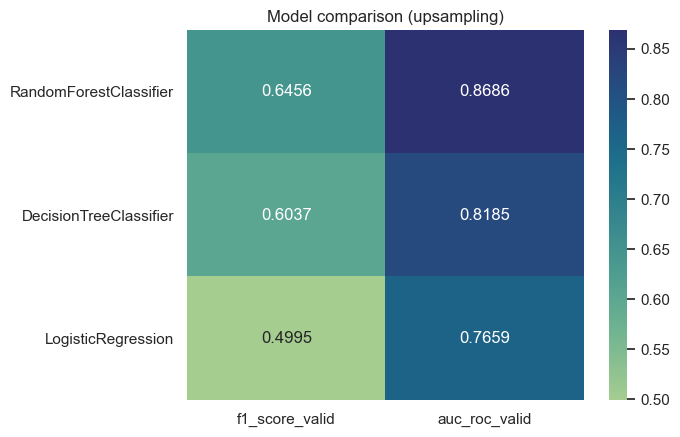


Best model: RandomForestClassifier(max_depth=9, n_estimators=60, random_state=12345)
Best F1-Score: 0.6456
Best AUC-ROC: 0.8686


In [42]:
# Creating a heatmap with results
cols = {
    "f1_score_valid": [best_result_DTC, best_result_RFC, best_result_log],
    "auc_roc_valid": [auc_roc_DTC, auc_roc_RFC, auc_roc_log],
}

models = [
    type(best_model_DTC).__name__,
    type(best_model_RFC).__name__,
    type(best_model_log).__name__,
]

df = pd.DataFrame(data=cols).set_index(pd.Series(models))
df_compare = df.sort_values(by="f1_score_valid", ascending=False)
heatmap = sns.heatmap(data=df_compare, annot=True, fmt=".4f", cmap="crest")
heatmap.set(title="Model comparison (upsampling)")
plt.show()

# Determining the best model
df_compare = df_compare.reset_index()

if df_compare["index"][0] == type(best_model_DTC).__name__:
    best_model_upsampled, best_f1_upsampled, best_auc_roc_upsampled = (
        best_model_DTC,
        best_result_DTC,
        auc_roc_DTC,
    )
elif df_compare["index"][0] == type(best_model_RFC).__name__:
    best_model_upsampled, best_f1_upsampled, best_auc_roc_upsampled = (
        best_model_RFC,
        best_result_RFC,
        auc_roc_RFC,
    )
else:
    best_model_upsampled, best_f1_upsampled, best_auc_roc_upsampled = (
        best_model_log,
        best_result_log,
        auc_roc_log,
    )
print(f"\nBest model: {best_model_upsampled}")
print(f"Best F1-Score: {best_f1_upsampled:.4f}")
print(f"Best AUC-ROC: {best_auc_roc_upsampled:.4f}")

The best model for the case of upsampling is a Random Forest with 60 trees, each with a depth of 9.

### Decreasing sample size

The last technique we will consider is downsampling, which is the opposite of upsampling: we decrease sample size to achieve class balance. This can also be done using `imblearn` library, where we will make use of `RandomUnderSampler()` from `under_sampling` module.

In [43]:
# Downsampling the training set
undersample = RandomUnderSampler(random_state=RANDOM_STATE)
features_train_downsampled, target_train_downsampled = undersample.fit_resample(
    features_train_scaled, target_train
)

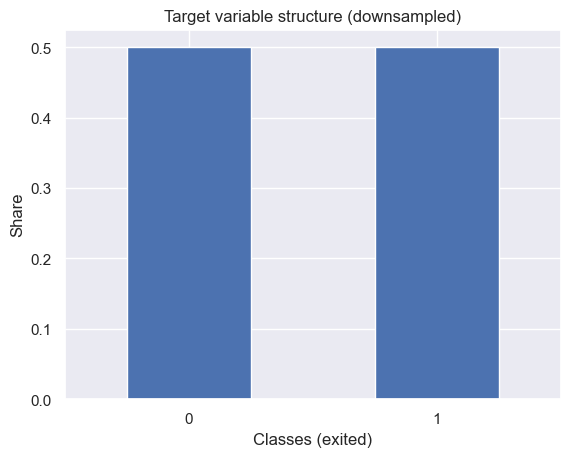

In [44]:
plot_class_structure(
    target_var=target_train_downsampled,
    xlabel_name="Classes (exited)",
    ylabel_name="Share",
    title_name="Target variable structure (downsampled)",
)

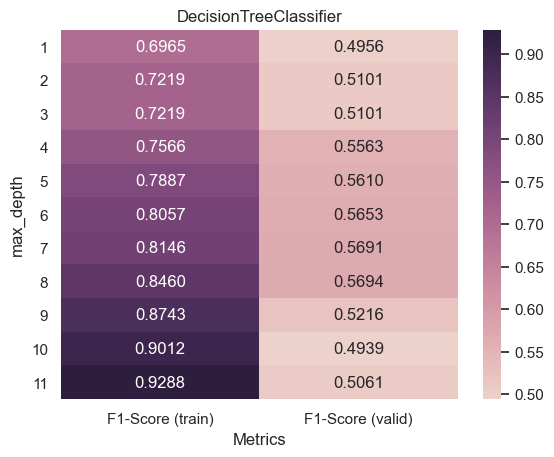


Best model: DecisionTreeClassifier(max_depth=8, random_state=12345)
Best F1-Score: 0.5694
AUC-ROC: 0.8060


In [45]:
# Upsampling
# Hyperparameter tuning (Decision Tree) -> {"max_depth"}
best_model_DTC = None
best_result_DTC = 0
max_depths = []
f1_train_scores = []
f1_valid_scores = []
for depth in range(1, MAX_DEPTH + 1):
    model = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=depth)
    model.fit(features_train_downsampled, target_train_downsampled)

    predictions_train = model.predict(features_train_downsampled)
    predictions_valid = model.predict(features_valid_scaled)

    f1_train = f1_score(target_train_downsampled, predictions_train)
    f1_valid = f1_score(target_valid, predictions_valid)

    max_depths.append(depth)
    f1_train_scores.append(f1_train)
    f1_valid_scores.append(f1_valid)

    if f1_valid > best_result_DTC:
        best_model_DTC = model
        best_result_DTC = f1_valid

cols = {"F1-Score (train)": f1_train_scores, "F1-Score (valid)": f1_valid_scores}
results = pd.DataFrame(cols).set_index(pd.Series(max_depths))
heatmap = sns.heatmap(
    data=results, annot=True, fmt=".4f", cmap=sns.cubehelix_palette(as_cmap=True)
)
heatmap.set(title=f"{type(model).__name__}", ylabel="max_depth", xlabel="Metrics")
plt.yticks(rotation=0)
plt.show()

print(f"\nBest model: {best_model_DTC}")
print(f"Best F1-Score: {best_result_DTC:.4f}")

probabilities_valid = best_model_DTC.predict_proba(features_valid_scaled)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc_DTC = roc_auc_score(target_valid, probabilities_one_valid)
print(f"AUC-ROC: {auc_roc_DTC:.4f}")

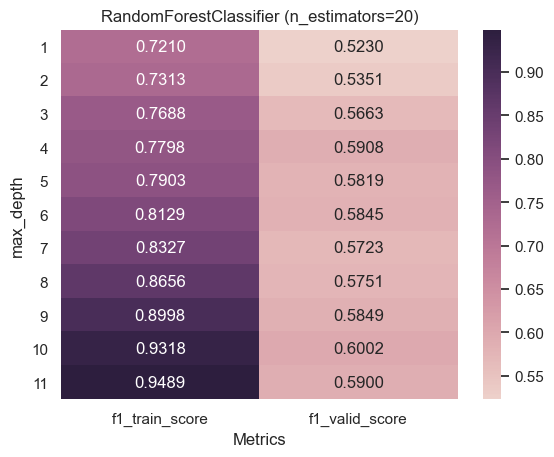

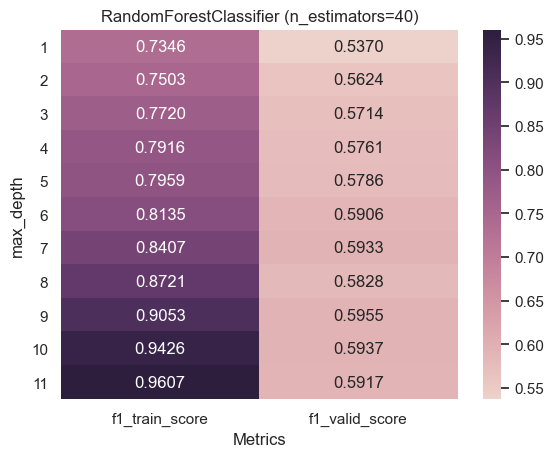

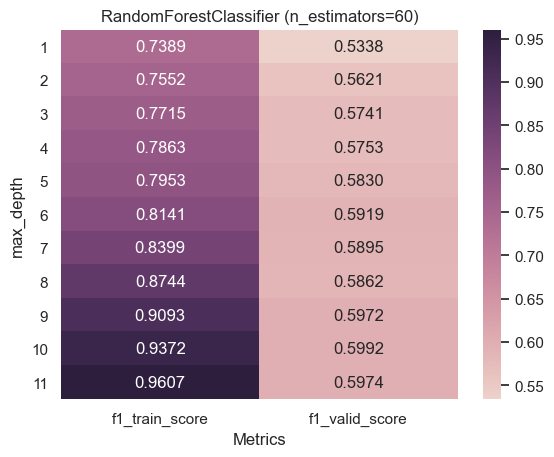

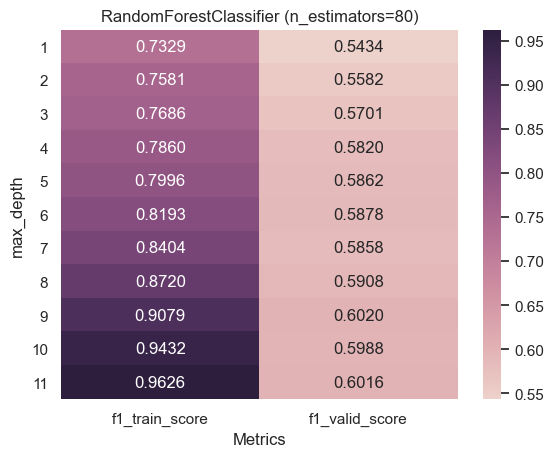

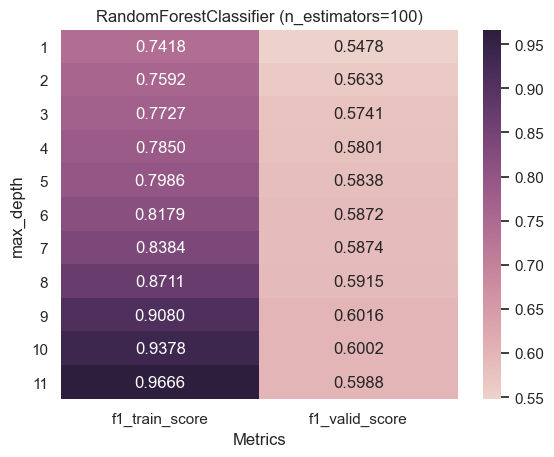


Best model: RandomForestClassifier(max_depth=9, n_estimators=80, random_state=12345)
Best F1-Score: 0.6020
AUC-ROC: 0.8686


In [46]:
# Upsampling
# Hyperparameter tuning (Random Forest) -> {"n_estimators", "max_depth"}
best_model_RFC = None
best_result_RFC = 0
for est in range(
    FOREST_SIZE_START, FOREST_SIZE_END + FOREST_SIZE_STEP, FOREST_SIZE_STEP
):
    max_depths = []
    f1_train_scores = []
    f1_valid_scores = []
    for depth in range(1, MAX_DEPTH + 1):
        model = RandomForestClassifier(
            random_state=RANDOM_STATE, n_estimators=est, max_depth=depth
        )
        model.fit(features_train_downsampled, target_train_downsampled)

        predictions_train = model.predict(features_train_downsampled)
        predictions_valid = model.predict(features_valid_scaled)

        f1_train = f1_score(target_train_downsampled, predictions_train)
        f1_valid = f1_score(target_valid, predictions_valid)

        max_depths.append(depth)
        f1_train_scores.append(f1_train)
        f1_valid_scores.append(f1_valid)

        if f1_valid > best_result_RFC:
            best_model_RFC = model
            best_result_RFC = f1_valid

    cols = {"f1_train_score": f1_train_scores, "f1_valid_score": f1_valid_scores}
    results = pd.DataFrame(cols).set_index(pd.Series(max_depths))
    heatmap = sns.heatmap(
        data=results, annot=True, fmt=".4f", cmap=sns.cubehelix_palette(as_cmap=True)
    )
    heatmap.set(
        title=f"{type(model).__name__} (n_estimators={est})",
        ylabel="max_depth",
        xlabel="Metrics",
    )
    plt.yticks(rotation=0)
    plt.show()

print(f"\nBest model: {best_model_RFC}")
print(f"Best F1-Score: {best_result_RFC:.4f}")

probabilities_valid = best_model_RFC.predict_proba(features_valid_scaled)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc_RFC = roc_auc_score(target_valid, probabilities_one_valid)
print(f"AUC-ROC: {auc_roc_RFC:.4f}")

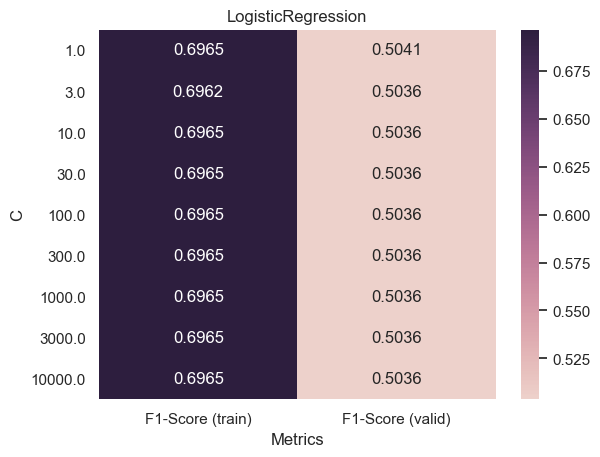


Best model: LogisticRegression(max_iter=1000, random_state=12345, solver='liblinear')
Best F1-Score: 0.5041
AUC-ROC: 0.7758


In [47]:
# Upsampling
# Hyperparameter tuning (Logistic Regression) -> {"C"}
best_model_log = None
best_result_log = 0
c_values = []
f1_train_scores = []
f1_valid_scores = []
for c in [1.0, 3.0, 10.0, 30.0, 100.0, 300.0, 1000.0, 3000.0, 10000.0]:
    model = LogisticRegression(
        random_state=RANDOM_STATE, solver="liblinear", max_iter=1000, C=c
    )
    model.fit(features_train_downsampled, target_train_downsampled)

    predictions_train = model.predict(features_train_downsampled)
    predictions_valid = model.predict(features_valid_scaled)

    f1_train = f1_score(target_train_downsampled, predictions_train)
    f1_valid = f1_score(target_valid, predictions_valid)

    c_values.append(c)
    f1_train_scores.append(f1_train)
    f1_valid_scores.append(f1_valid)

    if f1_valid > best_result_log:
        best_model_log = model
        best_result_log = f1_valid

cols = {"F1-Score (train)": f1_train_scores, "F1-Score (valid)": f1_valid_scores}
results = pd.DataFrame(cols).set_index(pd.Series(c_values))
heatmap = sns.heatmap(
    data=results, annot=True, fmt=".4f", cmap=sns.cubehelix_palette(as_cmap=True)
)
heatmap.set(title=f"{type(model).__name__}", ylabel="C", xlabel="Metrics")
plt.yticks(rotation=0)
plt.show()

print(f"\nBest model: {best_model_log}")
print(f"Best F1-Score: {best_result_log:.4f}")

probabilities_valid = best_model_log.predict_proba(features_valid_scaled)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc_log = roc_auc_score(target_valid, probabilities_one_valid)
print(f"AUC-ROC: {auc_roc_log:.4f}")

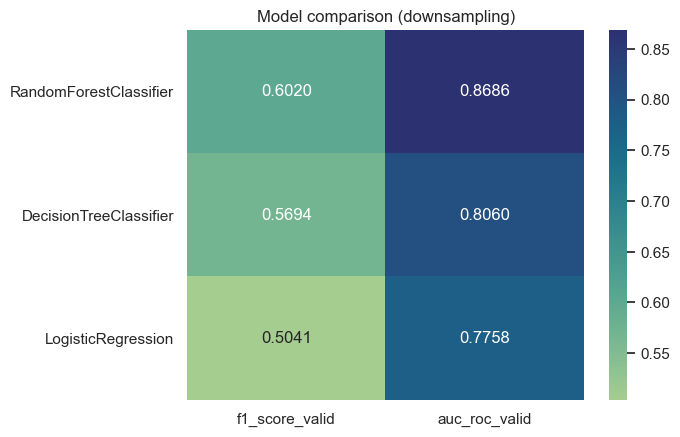


Best model: RandomForestClassifier(max_depth=9, n_estimators=80, random_state=12345)
Best F1-Score: 0.6020
Best AUC-ROC: 0.8686


In [48]:
# Creating a heatmap with results
cols = {
    "f1_score_valid": [best_result_DTC, best_result_RFC, best_result_log],
    "auc_roc_valid": [auc_roc_DTC, auc_roc_RFC, auc_roc_log],
}

models = [
    type(best_model_DTC).__name__,
    type(best_model_RFC).__name__,
    type(best_model_log).__name__,
]

df = pd.DataFrame(data=cols).set_index(pd.Series(models))
df_compare = df.sort_values(by="f1_score_valid", ascending=False)
heatmap = sns.heatmap(data=df_compare, annot=True, fmt=".4f", cmap="crest")
heatmap.set(title="Model comparison (downsampling)")
plt.show()

# Determining the best model
df_compare = df_compare.reset_index()

if df_compare["index"][0] == type(best_model_DTC).__name__:
    best_model_downsampled, best_f1_downsampled, best_auc_roc_downsampled = (
        best_model_DTC,
        best_result_DTC,
        auc_roc_DTC,
    )
elif df_compare["index"][0] == type(best_model_RFC).__name__:
    best_model_downsampled, best_f1_downsampled, best_auc_roc_downsampled = (
        best_model_RFC,
        best_result_RFC,
        auc_roc_RFC,
    )
else:
    best_model_downsampled, best_f1_downsampled, best_auc_roc_downsampled = (
        best_model_log,
        best_result_log,
        auc_roc_log,
    )
print(f"\nBest model: {best_model_downsampled}")
print(f"Best F1-Score: {best_f1_downsampled:.4f}")
print(f"Best AUC-ROC: {best_auc_roc_downsampled:.4f}")

The best model here is again a Random Forest with 80 trees and a depth of 9.

**Conclusion**

This section was devoted to applying techniques to combat class imbalance. We have managed to implement weighting classes, upsampling and downsampling in a series of hyperparameter tunings. All best models that have been detected within a particular method showed that the best-performing one is a Random Forest with *F1* scores larger than that in case of class imbalance being present.

## Final comparison

Now we are ready to compare the models. Let's create a table that will show which model we will end up testing.

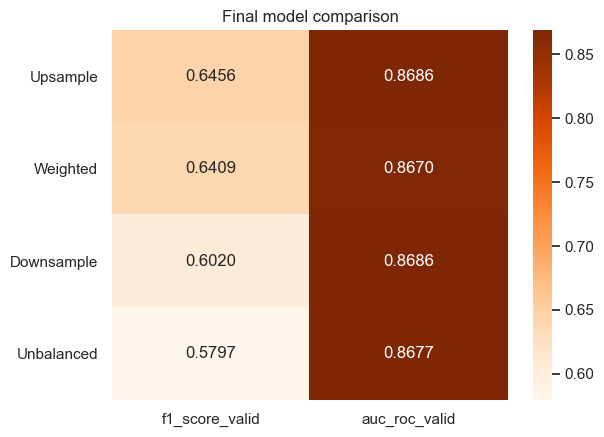


Final model: RandomForestClassifier(max_depth=9, n_estimators=60, random_state=12345)
Final F1-Score: 0.6456
Final AUC-ROC: 0.8686


In [49]:
# Creating a heatmap with results
cols = {
    "f1_score_valid": [
        best_f1_unbalanced,
        best_f1_weighted,
        best_f1_upsampled,
        best_f1_downsampled,
    ],
    "auc_roc_valid": [
        best_auc_roc_unbalanced,
        best_auc_roc_weighted,
        best_auc_roc_upsampled,
        best_auc_roc_downsampled,
    ],
}

methods = [
    "Unbalanced",
    "Weighted",
    "Upsample",
    "Downsample",
]

df = pd.DataFrame(data=cols).set_index(pd.Series(methods))
df_compare = df.sort_values(by="f1_score_valid", ascending=False)
heatmap = sns.heatmap(data=df_compare, annot=True, fmt=".4f", cmap="Oranges")
heatmap.set(title="Final model comparison")
plt.yticks(rotation=0)
plt.show()

# Determining the best model
df_compare = df_compare.reset_index()

if df_compare["index"][0] == "Unbalanced":
    best_model, best_f1, best_auc_roc = (
        best_model_unbalanced,
        best_f1_unbalanced,
        best_auc_roc_unbalanced,
    )
elif df_compare["index"][0] == "Weighted":
    best_model, best_f1, best_auc_roc = (
        best_model_weighted,
        best_f1_weighted,
        best_auc_roc_weighted,
    )
elif df_compare["index"][0] == "Upsample":
    best_model, best_f1, best_auc_roc = (
        best_model_upsampled,
        best_f1_upsampled,
        best_auc_roc_upsampled,
    )
    features_train_scaled = features_train_upsampled.copy()
    target_train = target_train_upsampled.copy()
else:
    best_model, best_f1, best_auc_roc = (
        best_model_downsampled,
        best_f1_downsampled,
        best_auc_roc_downsampled,
    )
    features_train_scaled = features_train_downsampled.copy()
    target_train = target_train_downsampled.copy()
print(f"\nFinal model: {best_model}")
print(f"Final F1-Score: {best_f1:.4f}")
print(f"Final AUC-ROC: {best_auc_roc:.4f}")

We see that the best model which outperforms others in terms of *F1* metric computed on the validation set proves to be a Random Forest model with 60 trees and a depth of 9 that resulted from applying upsampling method.

**Conclusion**

This short section showcased the model which we will eventually use for testing. The most preferrable method in our case is upsampling method.

## Testing 

Lastly, let's test the model and determine whether it passed all tests we have predefined.

In [50]:
# Testing the best model
best_model.fit(features_train_scaled, target_train)
predictions_test = best_model.predict(features_test_scaled)
f1_test = f1_score(target_test, predictions_test)
print(f"Tested model: {best_model}")
print(f"Test F1-Score: {f1_test:.4f}")

# Computing AUC-ROC
probabilities_valid = best_model.predict_proba(features_test_scaled)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc_test = roc_auc_score(target_test, probabilities_one_valid)
print(f"Test AUC-ROC: {auc_roc_test:.4f}")

# Running a dummy model
dummy_model = DummyClassifier(strategy="constant", constant=1)
dummy_model.fit(features_train_scaled, target_train)
dummy_predictions = dummy_model.predict(features_test_scaled)
f1_test_dummy = f1_score(target_test, dummy_predictions)

# Verifying model performance
assert f1_test >= F1_SCORE_THRESHOLD, "The model performance is unsatisfactory"
# Sanity check
assert (auc_roc_test > AUC_ROC_THRESHOLD) & (
    f1_test > f1_test_dummy
), "The model is inadequate"

# Summarizing the results in case the model passed the tests
recall_test = recall_score(target_test, predictions_test)
print(f"\nThe model correctly detects {recall_test:.1%} of churned clients.")

Tested model: RandomForestClassifier(max_depth=9, n_estimators=60, random_state=12345)
Test F1-Score: 0.6094
Test AUC-ROC: 0.8633

The model correctly detects 68.7% of churned clients.


Lastly, let's look at the model's results by plotting a confusion matrix.

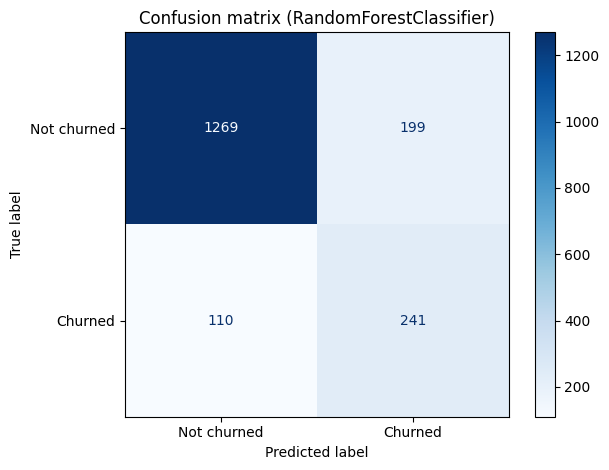

In [51]:
# Plotting confusion matrix
sns.reset_defaults()

cm = ConfusionMatrixDisplay.from_predictions(
    target_test,
    predictions_test,
    cmap=plt.cm.Blues,
    display_labels=["Not churned", "Churned"],
)

model_name = type(best_model).__name__
plt.title(f"Confusion matrix ({model_name})")
plt.tight_layout()
plt.show()

In [52]:
test_class_struct = target_test.value_counts()
test_class_struct.index = ["Not churned", "Churned"]
display(test_class_struct)

Not churned    1468
Churned         351
Name: exited, dtype: int64

## General conclusion

In this study, the data of "Beta Bank" customers were analyzed and an optimal model for predicting the clients churn from the bank was selected, which takes into account the features of the data, the most striking of which is the revealed fact of the presence of an imbalance of classes. The data has been thoroughly analyzed, preprocessed and prepared for their use in machine learning algorithms. 

The main part of the work consisted in carrying out several series of hyperparameter selections for the case of ignoring the imbalance and three cases of dealing with class imbalance, which include weighing classes, upsampling and downsampling. According to the results of the study, it turned out that, in comparison with ignoring the imbalance, the mentioned methods of dealing with the imbalance outperform the imbalanced model in terms of both *F1* and *AUC-ROC* metrics. The final model, which was chosen at the final stage, is a Random Forest with 60 trees, where each of them has a depth of 9. It is worth mentioning that it was the method of upsampling that allowed us to obtain such results. In the test sample, the model showed values of the metric *F1* at 0.6094, which is higher than the set threshold of 0.59. The model differs from the random one, which is manifested in a rather high value of the metric *AUC-ROC*.